In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

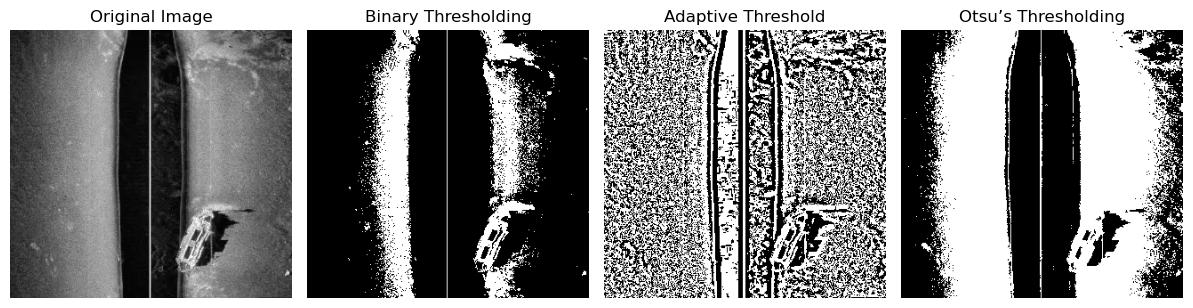

In [ ]:
image = cv2.imread('./sss_image.png', cv2.IMREAD_GRAYSCALE)

_, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                             cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ['Original Image', 'Binary Thresholding', 'Adaptive Threshold', 'Otsu’s Thresholding']
images = [image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Otsu's thresholding provides better thresholding 'cause it's based on nearby pixel intensity distribution.

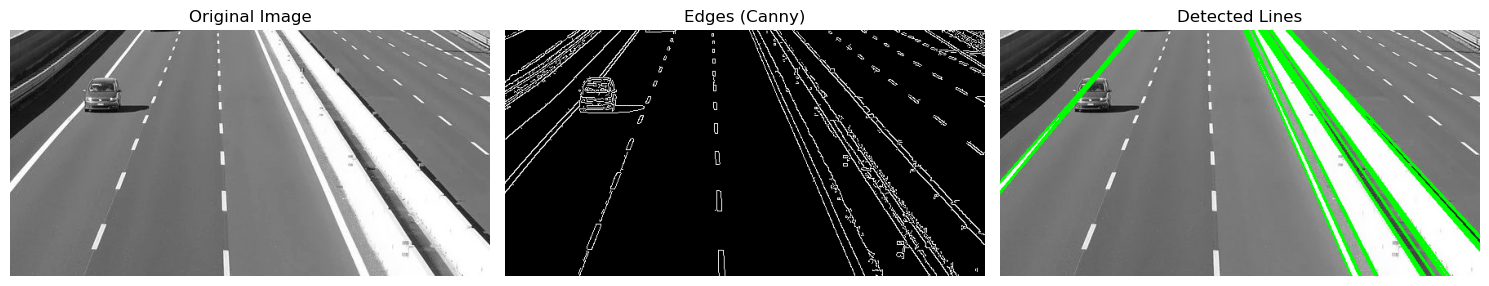

In [ ]:
def detectLinesHough(image_path, rho=1, theta=np.pi/180, threshold=100):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, rho, theta, threshold)
    
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return image, edges, color_image

image_path = 'hough-transform.png'  
original, edges, result = detectLinesHough(image_path, rho=1, theta=np.pi/360, threshold=150)

titles = ['Original Image', 'Edges (Canny)', 'Detected Lines']
images = [original, edges, result]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i] if i == 2 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Reduced rho increases precision of lines. Increasing threshold removes less prominent lines. Smaller theta values increases the accurate detection of angled lines

In [ ]:
def detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=0, maxRadius=0):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur for smoothing
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, minDist, 
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    
    # Draw the detected circles
    output_image = image.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round the values to integers
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # Circle center
            radius = circle[2]              # Circle radius
            cv2.circle(output_image, center, radius, (0, 255, 0), 2)  # Draw circle perimeter
            cv2.circle(output_image, center, 2, (0, 0, 255), 3)       # Draw circle center

    return gray_image, blurred_image, output_image

# Test the function
image_path = 'path_to_image.jpg'  # Replace with your image path
gray, blurred, result = detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=10, maxRadius=50)

# Display the results
titles = ['Grayscale Image', 'Blurred Image', 'Detected Circles']
images = [gray, blurred, result]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i] if i == 2 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()